# Scaffold hopping by holistic molecular representation in drug design

#### Francesca Grisoni,* Gisbert Schneider

ETH Zurich, Department of Chemistry and Applied Biosciences, RETHINK, Vladimir-Prelog-Weg 4, 8093, Zurich, Switzerland. <div>
*Corresponding author: francesca.grisoni@pharma.ethz.ch 


## Table of Contents
1. [Preliminary steps](#preliminary)
2. [Molecule import and pre-treatment](#import)
3. [WHALES descriptors](#whales) <div>
    a. [*WHALES calculation*](#calculation) <div>
    b. [*Descriptor scaling*](#scaling)
4. [Virtual screening](#vs)<div>
    a. [*Similarity calculation*](#similarity)<div>
    b. [*Identification of top hits*](#tophits)<div>
5. [Scaffold analysis](#scaffold)<div>
    a. [*Template scaffold*](#templatescaffold)<div>
    b. [*Library scaffold diversity*](#libraryscaffold)<div>
    c. [*Scaffold diversity of the top hits*](#tophitsscaffold)<div>
6. [How to cite](#cite) 

# Import of necessary packages <a name="preliminary"></a>

Here you will find all of the necessary packages that will be used in this Jupyter Notebook. No worries, they should all be installed already in your virtual environment!

In [1]:
# chemistry toolkits
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw # for molecule depiction
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds import MurckoScaffold

# for data analysis and plotting
# WHALES-related code

import whales
# to delete before uploading
%load_ext autoreload
%autoreload
%reload_ext whales

# Molecule import and pre-treatment <a name="import"></a>

## Template molecule

Import and visualization of galantamine, starting from SMILES

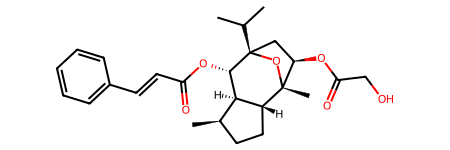

In [2]:
# import template from SMILES
template = Chem.MolFromSmiles('C[C@@H]1CC[C@@H]2[C@@H]1[C@@H]([C@@]3(C[C@H]([C@]2(O3)C)OC(=O)CO)C(C)C)OC(=O)/C=C/c4ccccc4') # imports from SMILES
# add 2D coordinates for visualization
err = whales.Compute2DCoords(template)
template

Prepare the molecule, by checking for errors and optimizing the 3D conformation

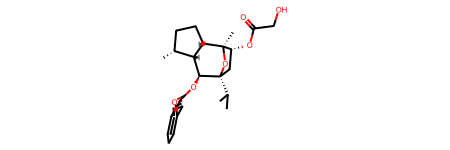

In [3]:
mol, name, err = whales.PrepareMol(template)
mol

Inspect the partial charges that will be used for WHALES calculation

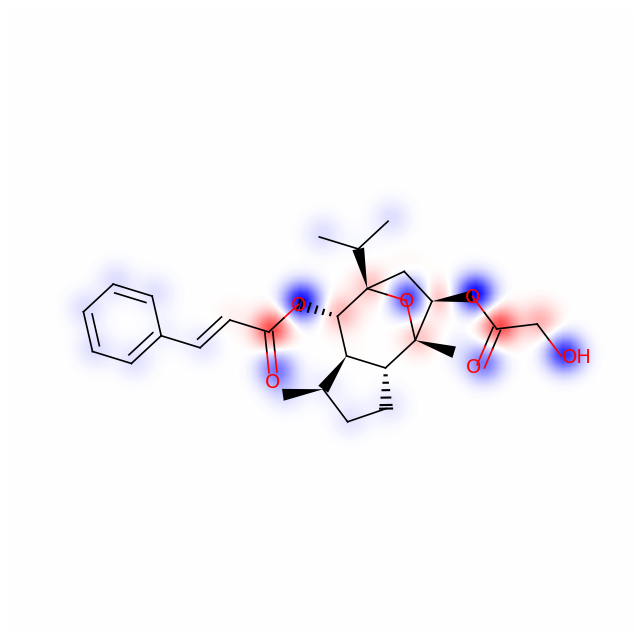

In [4]:
whales.PlotChargeMap(template,lab_atom=True)

In [6]:
writer = Chem.rdmolfiles.SDWriter('out.sdf')
writer.write(mol)

## Compound library

Import and prepare library

In [5]:
# set the path to the sdf file for input and output
input_filename = 'scaffold_hopping_whales/data/library.sdf'
vs_library_2D = Chem.SDMolSupplier(input_filename) # conserved for 2D representations
vs_library = whales.PrepareMolFromSDF(input_filename) # computes 3D geometry from a specified sdf file

100%|██████████| 1000/1000 [00:30<00:00, 32.86it/s]


Visually inspect the database after geometry optimization

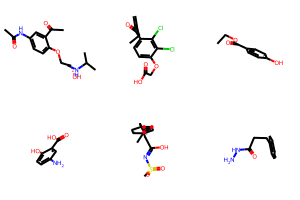

In [6]:
#Visualize the first 6 molecules of the database after geometry optimization
n_mols = 6 # number of molecules to inspect
Draw.MolsToGridImage(vs_library[:n_mols],molsPerRow=3,subImgSize=(100,100),legends=[x.GetProp("_Name") for x in vs_library[:n_mols]])

# WHALES descriptors <a name="whales"></a>

## Descriptors calculation <a name="calculation"></a>

Compute WHALES descriptors for the template molecule

In [32]:

import pandas as pd
from tqdm import tqdm

In [17]:
# compute descriptors as an array
whales_template = whales.GetFingerprint(template)
# convert the arrays into a pandas dataframe
matrix = whales_template.reshape(-1, len(whales_template))
strings = ["R_", "I_", "IR_"]
start, end, step = 0, 100, 10
perc = [i for i in range(start, end + 1, step)]
lab_string = ''
labels = [f"{j}{lab_string}{int(i / 10)}" for j in strings for i in perc]
df_whales_template = pd.DataFrame(matrix,index=['template'],columns=labels)
df_whales_template

,R_0,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,...,IR_1,IR_2,IR_3,IR_4,IR_5,IR_6,IR_7,IR_8,IR_9,IR_10
template,-2.202,-1.59,-1.413,-1.17,-0.953,-0.723,-0.479,0.07,0.392,0.481,...,-0.088,-0.054,-0.038,-0.029,-0.022,-0.017,0.018,0.059,0.147,0.226


Compute WHALES for the virtual screening library

In [33]:
whales_library = []
for mol in tqdm(vs_library): # runs over the library and updates WHALES
    whales_temp = whales.GetFingerprint(mol)
    whales_library.append(whales_temp)
# convert the arrays into a pandas dataframe
cc_whales_library = whales.StackFingerprints(whales_library)
df_whales_library = whales.GetDataFrame(cc_whales_library)
df_whales_library.head() # library preview

,R_0,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,...,IR_1,IR_2,IR_3,IR_4,IR_5,IR_6,IR_7,IR_8,IR_9,IR_10
0,-3.871,-1.559,-1.263,-0.987,-0.498,-0.420,0.372,0.531,0.871,1.185,...,-0.171,-0.146,-0.094,-0.063,-0.020,0.034,0.061,0.090,0.158,0.182
1,-5.197,-2.547,-1.765,-1.327,-1.075,-0.650,-0.502,0.393,0.612,0.734,...,-0.172,-0.145,-0.124,-0.094,-0.049,-0.044,0.114,0.201,0.290,0.521
2,-21.571,-1.253,-1.016,-0.962,-0.879,-0.790,-0.712,-0.031,0.372,0.484,...,-0.120,-0.099,-0.091,-0.082,-0.057,-0.026,0.031,0.099,0.179,0.431
3,-1.804,-1.409,-1.120,-1.075,-1.061,-0.991,-0.900,0.463,0.513,0.567,...,-0.351,-0.287,-0.204,-0.163,-0.092,-0.080,0.045,0.458,0.471,0.621
4,-3.060,-2.078,-1.765,-1.497,-1.182,-0.925,-0.854,-0.740,-0.188,0.744,...,-0.407,-0.195,-0.162,-0.134,-0.089,-0.084,-0.039,0.037,0.172,0.814


## Descriptors scaling <a name="scaling"></a>

### Data visualization
Visualizing the raw descriptor values for the virtual screening library using a boxplot

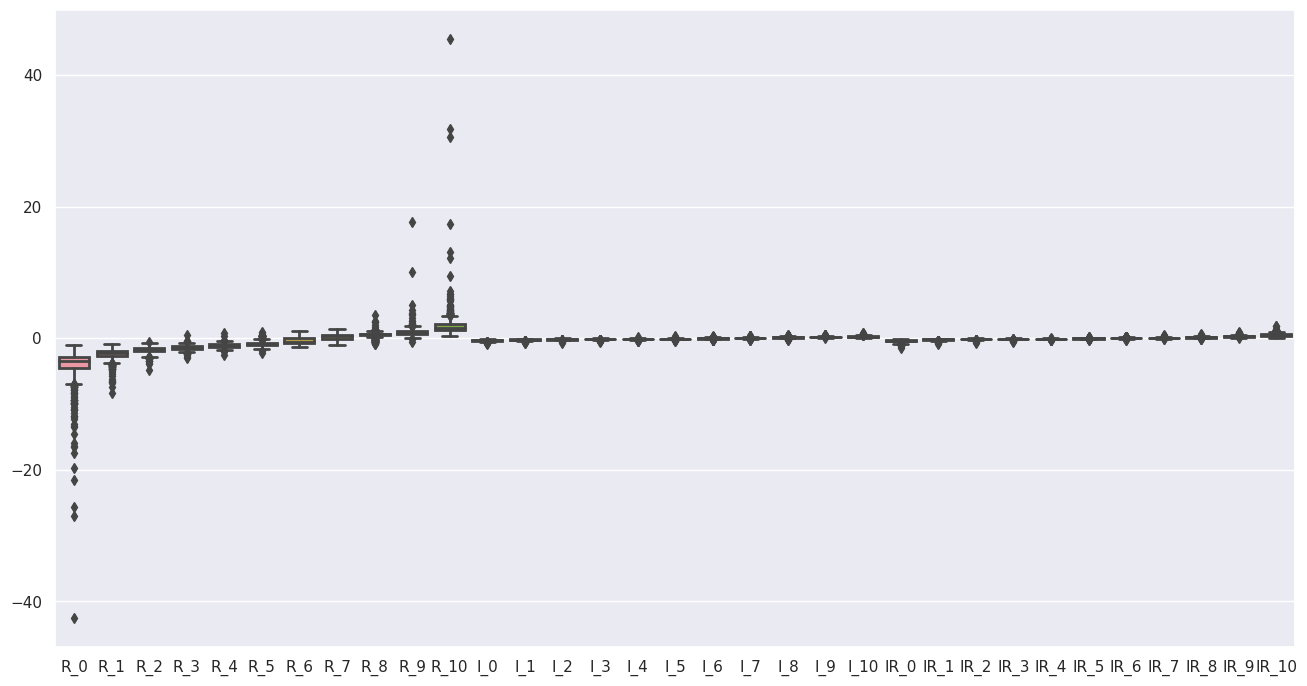

In [34]:
whales.PlotDataFrame(df_whales_library)

### Autoscaling

Virtual library scaling

In [58]:
df_whales_library_scaled, avg, std = whales.ScaleFingerprints(df_whales_library)

Template scaling

In [59]:
df_whales_template_scaled, _, _ = whales.ScaleFingerprints(df_whales_template, avg, std)
df_whales_template_scaled

,R_0,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,...,IR_1,IR_2,IR_3,IR_4,IR_5,IR_6,IR_7,IR_8,IR_9,IR_10
template,0.710363,1.061499,0.832982,0.725334,0.600081,0.292101,-0.19224,-0.247131,-0.531925,-0.648783,...,1.379514,1.408386,1.367847,1.221851,0.730067,-0.141426,-0.578777,-1.105002,-1.128919,-1.289052


### Data visualization
Visualizing the descriptor values for the virtual screening library after autoscaling


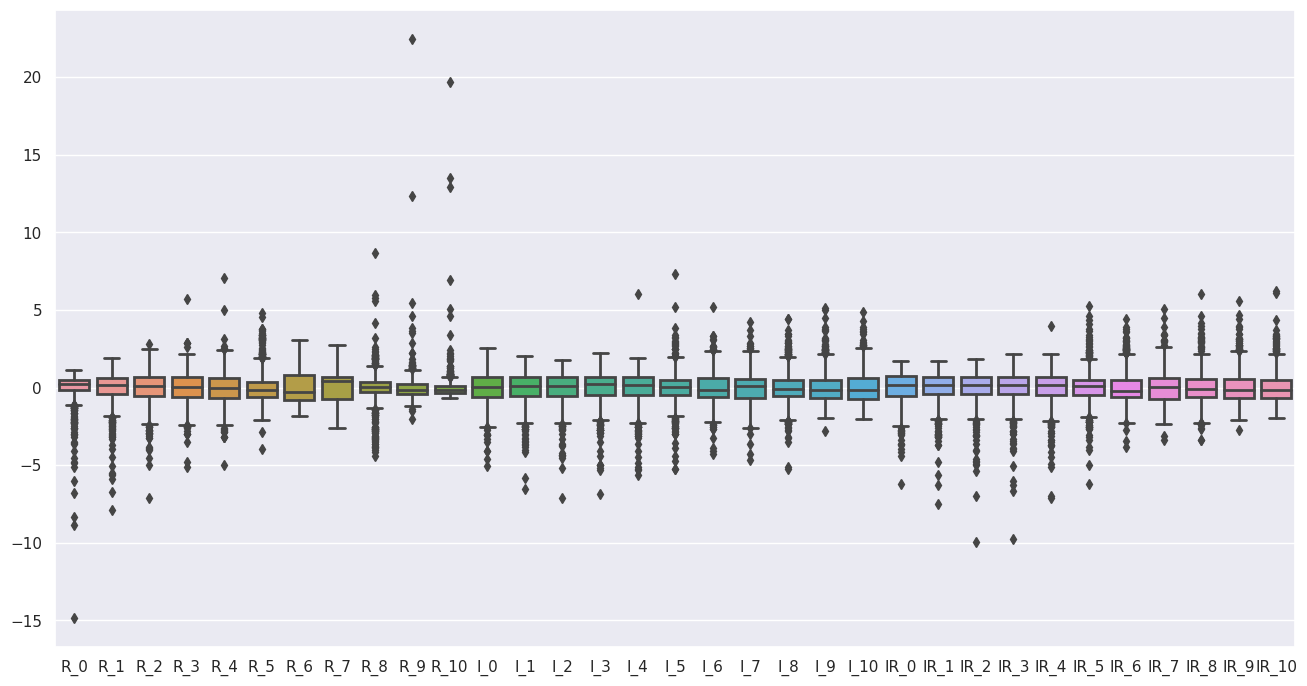

In [60]:
whales.PlotDataFrame(df_whales_library_scaled)

# Virtual screening <a name="vs"></a>

## Similarity calculation <a name="similarity"></a>

In [66]:
# compute Euclidean distance
D = whales.CalcSimilarityMatrix(df_whales_template_scaled, df_whales_library_scaled)

## Identification of top hits <a name="tophits"></a>
Selection of the 10 closest compounds based on the computed distance on WHALES

In [71]:
# sorting based on distance
top_k = whales.GetTopK(D, k=10)
top_k

array([[710, 940, 869, 136, 119, 569, 921,  87, 449, 335]])

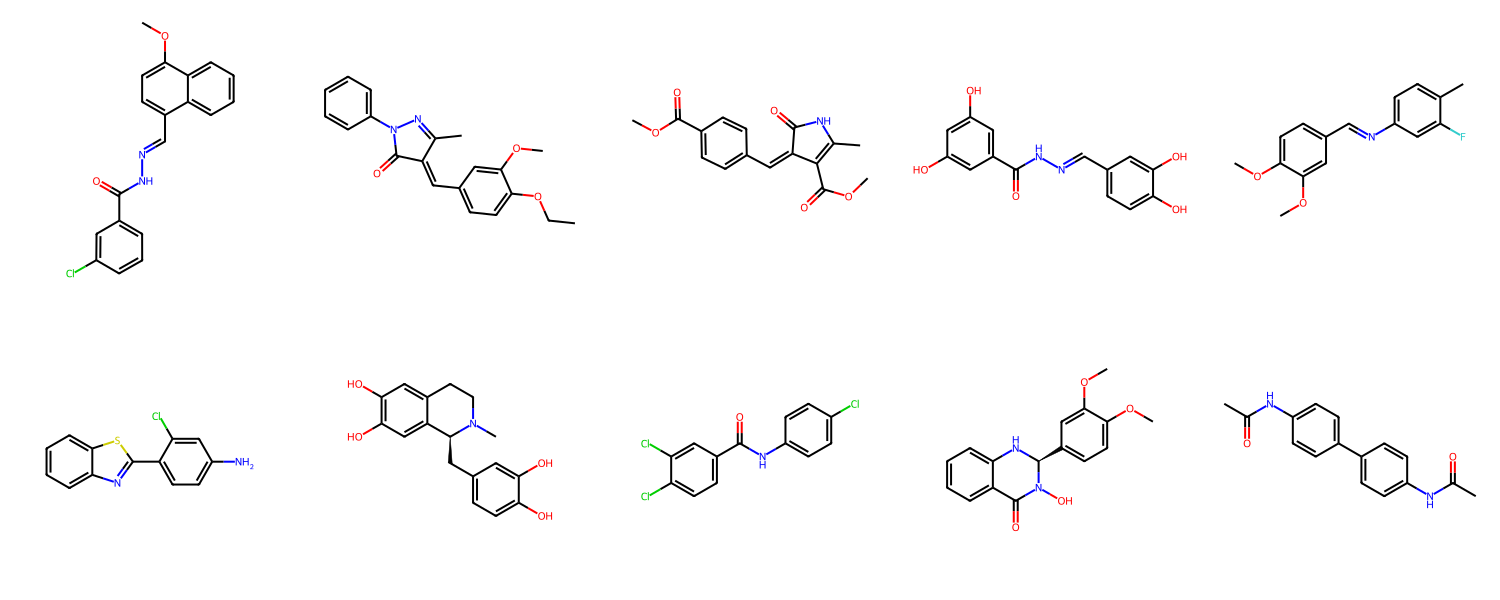

In [73]:
# display of the 10 closest compounds
import numpy
hits = []
smiles_hits = []
for j in numpy.nditer(top_k):
    hits.append(vs_library_2D[int(j)])
    smiles_hits.append(Chem.MolToSmiles(mol))

#Visualize the first 10 molecules of the database after geometry optimization
n_mols = 10 # number of molecules to inspect
Draw.MolsToGridImage(hits[:n_mols+1],molsPerRow=5,subImgSize=(300,300),legends=[x.GetProp("_Name") for x in hits[:n_mols+1]])

# Scaffold analysis <a name="scaffold"></a>

## Template scaffold <a name="templatescaffold"></a>

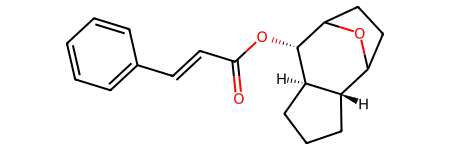

In [76]:
core = whales.GetMurckoScaffold(template)
core

## Scaffold diversity of the virtual screening library

Compute the Bemis-Murcko scaffolds for the virtual screening library

In [77]:
scaffold_vs = [] # generates an empty supplier to contain the computed scaffold
for mol in tqdm(vs_library_2D):
    scaffold_vs.append(MurckoScaffold.GetScaffoldForMol(mol))

100%|██████████| 1000/1000 [00:00<00:00, 7956.94it/s]


Preview of the scaffolds (4 for display)

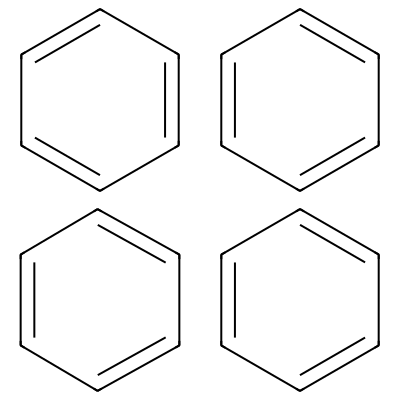

In [78]:
# 4 scaffolds are displayed
k = 4
Draw.MolsToGridImage(scaffold_vs[:k],molsPerRow=2,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in scaffold_vs[:k]])

Most frequently recurring scaffolds in the virtual screening library

In [79]:
freq_scaffolds_library = whales.GetFrequentScaffolds(vs_library_2D) # contains the list of the (unique) scaffolds, sorted by number

Display the four most occurring scaffolds

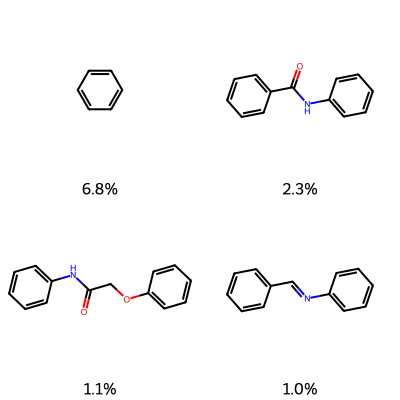

In [80]:
k = 4
Draw.MolsToGridImage(freq_scaffolds_library[:k],molsPerRow=2,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in freq_scaffolds_library[:k]])

Computes the relative scaffold diversity of the library

In [81]:
SD_rel = len(freq_scaffolds_library)/len(vs_library)*100
print(SD_rel)

54.2


## Top hits scaffolds

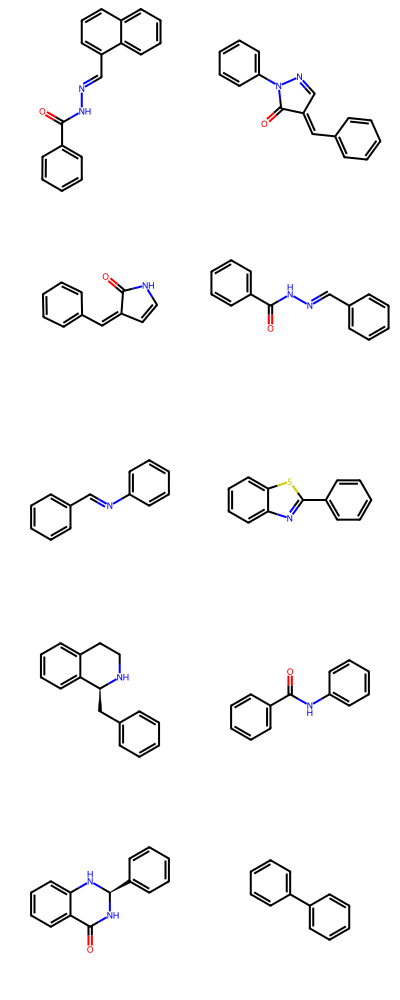

In [82]:
scaffold_hits = []
for mol in hits:
    scaffold_hits.append(whales.GetMurckoScaffold(mol))
 
Draw.MolsToGridImage(scaffold_hits[:10],molsPerRow=2,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in scaffold_hits[:10]])

Computes the frequent scaffolds and the scaffold diversity

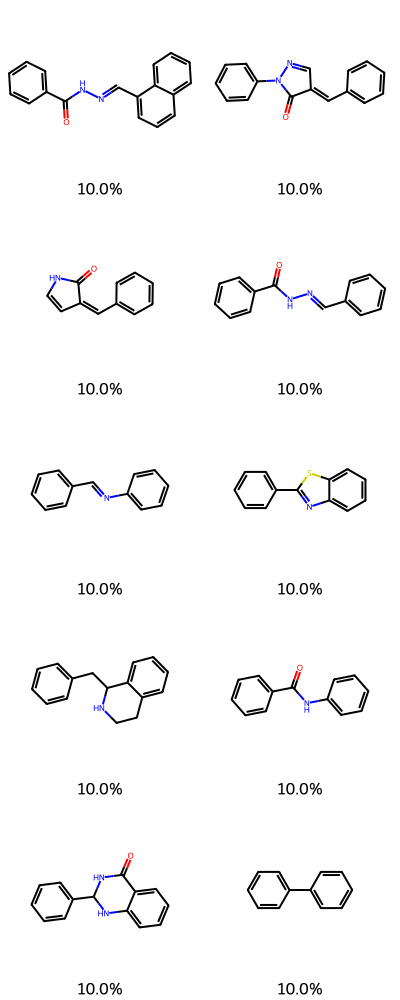

In [83]:
freq_scaffolds_hits = whales.GetFrequentScaffolds(hits) # contains the list of the (unique) scaffolds, sorted by number
k = len(freq_scaffolds_hits) # display all scaffolds
Draw.MolsToGridImage(freq_scaffolds_hits[:k],molsPerRow=2,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in freq_scaffolds_hits[:k]])

In [84]:
SD_rel = len(freq_scaffolds_hits)/len(hits)*100
print(SD_rel)

100.0
